In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import fsolve
from scipy.optimize import brentq

#General parameters in SI
G=6.6743e-11 #m^3 kg^-1 s^-2
c=3e8 #m/s
h_t=1.054571817e-34 #kg*m^2*s^-2
m_e=9.1093837015e-31 #kg
m_n=1.674927351e-27 #kg
m_p=1.672621923691e-27 #kg
m_sun=1.98855e30 #kg



In [2]:
#Building the equation of state

e0_p = m_p**4 * c**5 / (np.pi**2 * h_t**3)
e0_n = m_n**4 * c**5 / (np.pi**2 * h_t**3)
e0_e = m_e**4 * c**5 / (np.pi**2 * h_t**3)

#Define dimensionless quantities for the root finding of the momentum

#Dimensionless parameter for the proton w=k_p/(m_p*c) as a function of x=k_n/(m_n*c)
def proton_w(x):
    term1 = (x**2 + 1 - (m_e**2 / m_n**2))**2
    term2 = -2 * (m_p**2 / m_n**2) * (x**2 + 1 + (m_e**2 / m_n**2))
    term3 = (m_p**4 / m_n**4)
    numerator = np.sqrt(m_n**4 * (term1 + term2 + term3))
    denominator = 2 * m_p * m_n * np.sqrt(x**2 + 1)
    return numerator / denominator

#Dimensionless parameter for the electron z=k_e/(m_e*c)=k_p/(m_e*c) as a function of w=k_p/(m_p*c)
def electron_z(w):
    return w * (m_p / m_e)

#Define difference between pressure given by protons, electrons and neutrons and a given pressure
def pressure_tot_func(x, p_g):
    w = proton_w(x)
    z = electron_z(w)
    p_p = e0_p / 24 * ((2 * w**3 - 3 * w) * np.sqrt(1 + w**2) + 3 * np.arcsinh(w))
    p_e = e0_e / 24 * ((2 * z**3 - 3 * z) * np.sqrt(1 + z**2) + 3 * np.arcsinh(z))
    p_n = e0_n / 24 * ((2 * x**3 - 3 * x) * np.sqrt(1 + x**2) + 3 * np.arcsinh(x))
    return p_n + p_e + p_p - p_g

#Define energy density given by protons, electrons and neutrons
def energy_tot_func(x):
    w = proton_w(x)
    z = electron_z(w)
    e_p = e0_p / 8 * ((2 * w**3 + w) * np.sqrt(1 + w**2) - np.arcsinh(w))
    e_e = e0_e / 8 * ((2 * z**3 + z) * np.sqrt(1 + z**2) - np.arcsinh(z))
    e_n = e0_n / 8 * ((2 * x**3 + x) * np.sqrt(1 + x**2) - np.arcsinh(x))
    return e_n + e_e + e_p


#Define difference between pressure given only by protons and electrons and a given pressure (happens under critical p)
def pressure_1tot_func(u, p_g):
    z = electron_z(u)
    p_p = e0_p / 24 * ((2 * u**3 - 3 * u) * np.sqrt(1 + u**2) + 3 * np.arcsinh(u))
    p_e = e0_e / 24 * ((2 * z**3 - 3 * z) * np.sqrt(1 + z**2) + 3 * np.arcsinh(z))
    return p_p + p_e - p_g

#Define energy density when there are only protons and electrons, which happens under a critical pressure
def energy_1tot_func(u):
    z = electron_z(u)
    e_p = e0_p / 8 * ((2 * u**3 + u) * np.sqrt(1 + u**2) - np.arcsinh(u))
    e_e = e0_e / 8 * ((2 * z**3 + z) * np.sqrt(1 + z**2) - np.arcsinh(z))
    return e_p + e_e


In [3]:
#Define total energy density: this function gives me the corresponding energy density for a given p
#taking into account that there exists a critical pressure
def energy_density(p):
    p_threshold = 3.054e23
    
    if p < p_threshold:
        root = brentq(pressure_1tot_func, -1000, 1000, args=(p,))
        return energy_1tot_func(root)
    else:
        root = brentq(pressure_tot_func, -1000, 1000, args=(p,))
        return energy_tot_func(root)


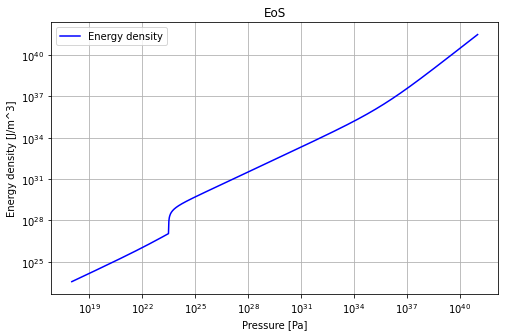

In [11]:
#EoS
p_values = np.logspace(18, 41, 1000)
e_values = [energy_density(p) for p in p_values]

plt.figure(figsize=(8, 5))
plt.plot(p_values, e_values, 'b-', label="Energy density")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Pressure [Pa]')
plt.ylabel('Energy density [J/m^3]')
plt.legend()
plt.title('EoS')
plt.grid()
plt.show()

In [5]:
def tov_equations(r, y):
    p, m = y
    if p <= 0:
        return np.array([0, 0])
    e=energy_density(p)
    dmdr = 4 * np.pi * r**2 * e / c**2
    dpdr = -G * e * m / (c**2 * r**2) * (1 + p / e) * (1 + 4 * np.pi * r**3 * p / (m * c**2)) / (1 - 2 * G * m / (c**2 * r))
    return [dpdr, dmdr]


def solve_tov(p_c):
    y0 = [p_c, 1e-6]  
    r_span = (1e-6, 3e7)

    sol = solve_ivp(tov_equations, r_span, y0, method='LSODA', max_step=5e2)
    return sol


In [6]:
#pressure in the centre of the neutron star VARYING
p_c_values1 = np.logspace(22, 29, 58)

# Lists to store results
M_stars1 = []
r_stars1 = []


# Solve FOR MANY POSSIBLE INTERNAL PRESSURES
for p_c in p_c_values1:
 
    sol = solve_tov(p_c)
    m_values1= sol.y[1]/m_sun
    p_values1= sol.y[0]
    r_values1=sol.t*10**(-3)

    for i in range(len(p_values1)):
        if p_values1[i]<=1e18:
            r_stop1 = r_values1[i]  # Neutron star's radius
            M_star1 = m_values1[i]   # Neutron star's mass
            break
            
    
    M_stars1.append(M_star1)
    r_stars1.append(r_stop1)


M_stars1 = np.array(M_stars1)
r_stars1 = np.array(r_stars1)


p_c_values2 = np.logspace(29, 39, 80)

# Lists to store results
M_stars2 = []
r_stars2 = []


# Solve FOR MANY POSSIBLE INTERNAL PRESSURES
for p_c in p_c_values2:
 
    sol = solve_tov(p_c)
    m_values2= sol.y[1]/m_sun
    p_values2= sol.y[0]
    r_values2=sol.t*10**(-3)

    for i in range(len(p_values2)):
        if p_values2[i]<=0:
            r_stop2 = r_values2[i]   # Neutron star's radius
            M_star2 = m_values2[i]  # Neutron star's mass
            break
            
    
    M_stars2.append(M_star2)
    r_stars2.append(r_stop2)


M_stars2 = np.array(M_stars2)
r_stars2 = np.array(r_stars2)




In [7]:
M_stars = np.concatenate([M_stars1, M_stars2])
r_stars = np.concatenate([r_stars1, r_stars2])
p_c_values = np.concatenate([p_c_values1, p_c_values2])


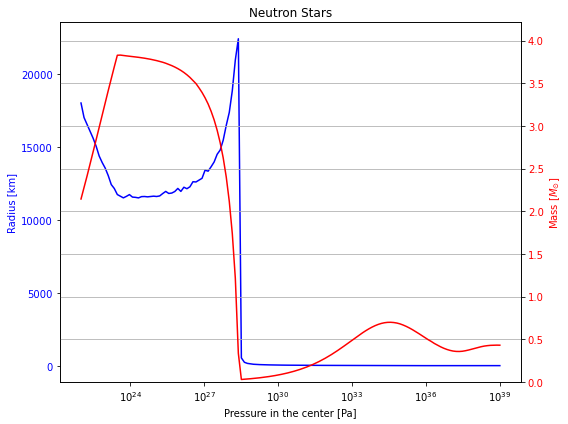

In [8]:
fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.plot(p_c_values, r_stars , 'b-', label="Radius[km]")
ax1.set_xlabel("Pressure in the center [Pa]")
ax1.set_ylabel("Radius [km]", color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xscale('log')
ax2 = ax1.twinx()  
ax2.plot(p_c_values, M_stars, 'r-', label="Mass [$M_{\odot}$]")
ax2.set_ylabel("Mass [$M_{\odot}$]", color='r')
ax2.tick_params(axis='y', labelcolor='r')
plt.ylim(0, max(M_stars) * 1.1)
plt.title("Neutron Stars")
fig.tight_layout()
plt.grid()
plt.show()



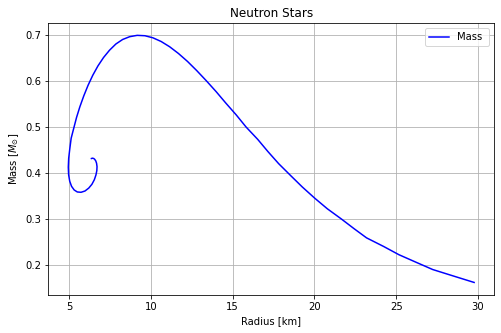

In [9]:
thr=1e31

mask = p_c_values > thr
filtered_p_c_values = p_c_values[mask]
filtered_r_stars = r_stars[mask]
filtered_M_stars = M_stars[mask]

#Plot with R changing
plt.figure(figsize=(8, 5))
plt.plot(filtered_r_stars, filtered_M_stars,  'b-', label="Mass ")
plt.xlabel('Radius [km]')
plt.ylabel('Mass [$M_{\odot}$]')
plt.legend()
plt.title('Neutron Stars')
plt.grid()
plt.show()


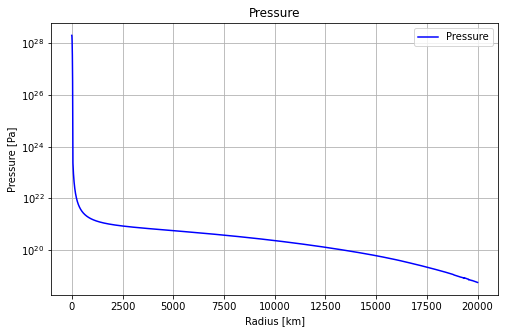

In [10]:
#Only for a given central pressure to see that around this value one needs a cut-off on the pressure 
#to get the actual radius and mass of the neutron star
def solve_tov(p_c):
    
    y0 = [p_c, 1e-6]  
    r_span = (1e-6, 2e7)

    sol = solve_ivp(tov_equations, r_span, y0, method='LSODA', max_step=1e3)
    return sol

sol = solve_tov(2e28)

m_values= sol.y[1]/m_sun
p_values= sol.y[0]
r_values=sol.t*10**(-3)

#Plot with R changing
plt.figure(figsize=(8, 5))
plt.plot(r_values, p_values,  'b-', label="Pressure")
plt.yscale('log')
plt.xlabel('Radius [km]')
plt.ylabel('Pressure [Pa]')
plt.legend()
plt.title('Pressure')
plt.grid()
plt.show()
